In [128]:
from astropy.wcs import WCS
from astropy import wcs
from astropy.io import fits, ascii
from astropy.coordinates import Angle, SkyCoord
from astropy.nddata import Cutout2D
from astropy.modeling import models, fitting
from astropy import time
from astropy.constants import mu0, m_p, m_e, k_B
import astropy.units as un
import numpy as np
import pandas as pd


from matplotlib.patches import Ellipse, Rectangle, Arc
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, FixedFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D

#these are all for the line fitting, which moved
from scipy.optimize import curve_fit, minimize
import scipy.stats as stats
from scipy.special import gamma


import math
from IPython.display import display, Math, Latex

import sys
import warnings
warnings.filterwarnings("ignore");

#### To-Do

1. Make a check to see if all packages are imported, at least IPython.display.display & math
2. Make a joined pressure and B field one
3. see how to put functions and what not in a standalone file
4. Figure out what I changed with the difmap_model_read
5. Clear the line-fitting stuff to therealemcee_final
6. Brightness T; formatting
7. Beam & Scale bar are not cutout independent


#### Functions 

In [169]:
#-------------------------------------------------reading in files & whatnot fqns----------------------------------------------------------------------------
def beam(hdu):
    """input fits hdu"""
    beam_dict = {};
    beam_dict = {"b_major": hdu.header['BMAJ'], "b_minor": hdu.header['BMIN'], "b_pa": hdu.header['BPA']};
    #All units in degree
    
    return(beam_dict)


def info(hdu, in_center_dict=None):
    """inpt fits hdu"""
    if (str(hdu.__class__) == "<class 'astropy.io.fits.hdu.image.PrimaryHDU'>"):
        
        info_dict = {};
        info_dict = { "obs_code": hdu.header['OBSERVER'], "obs_date": hdu.header['DATE-OBS'],
                 "obsra": hdu.header['OBSRA'], "obsdec": hdu.header['OBSDEC'],
                 "rms": hdu.header['NOISE'], "min": hdu.header['DATAMIN'], "max": hdu.header['DATAMAX']};
        center_dict = {};
        center_dict = {"centpxl_ra": hdu.header['CRPIX1'], "centpxl_dec": hdu.header['CRPIX2'],
                "center_ra": hdu.header['CRVAL1'], "center_dec": hdu.header['CRVAL2'],
                "scale_ra": hdu.header['CDELT1'], "scale_dec": hdu.header['CDELT2'],
                "npxl_ra": hdu.header['NAXIS1'], "npxl_dec": hdu.header['NAXIS2']};
        return(info_dict, center_dict);
        
    elif (str(hdu.__class__) == "<class 'astropy.io.fits.header.Header'>"):
        
        info_dict = {};
        info_dict = { "obs_date": hdu['DATE-OBS']};
        center_dict = in_center_dict;
        center_dict |= {"centpxl_ra": hdu['CRPIX1'], "centpxl_dec": hdu['CRPIX2'],
                "center_ra": hdu['CRVAL1'], "center_dec": hdu['CRVAL2'],
                "scale_ra": hdu['CDELT1'], "scale_dec": hdu['CDELT2']};
        return(info_dict, center_dict);
    else:
        print("The input is not a hdu object, it's:",str(hdu.__class__));

def load(filename):
    """input filename/path, will output hdu data, wcs, and hdu."""
    hdu = fits.open(filename)[0];
    hdu_data = hdu.data[0][0];
    wcs_tmp = WCS(hdu.header);
    wcs_tmp1 = wcs_tmp.dropaxis(3);
    wcs = wcs_tmp1.dropaxis(2);
    
    return(hdu_data, wcs, hdu)

def difmap_model_read(modelfit_file):
    """reads the output of difmap model files, path to file is needed."""
    header_names = ['Flux (Jy)', 'Flux (jy) Std', 'East (arcsec)', 'RA (arcsec) Std', 'North (arcsec)', 'Dec (arcsec) Std', 'Shape', 'R.A. (deg)', 'Dec (deg)',
        'Major FWHM (arcsec)', 'Major Std', 'Minor FWHM (arcsec)', 'Minor Std', 'Theta (deg)', 'Theta Std', 'Freq (Hz)', 'Spectral Index', 'Spec Indx Std' ];
    
    difmap_df = pd.read_csv(modelfit_file, header=None, sep=r'\s+', skiprows=[0,1,2], engine='python', names=header_names, skipinitialspace=True);
    # difmap_coords = 1;
    difmap_coords = SkyCoord(difmap_df.iloc[0,7], difmap_df.iloc[0,8], unit=(un.degree, un.degree),
                             obstime="J2000", frame='fk5');

    return(difmap_df, difmap_coords);

#-------------------------------------------------plotting & imaging fqns----------------------------------------------------------------------------
## Cutting function
def cut(data, in_wcs, center_dict, center_pos, box):
    """input data, wcs, center dictionary, center position and size of cutout."""
    size = un.Quantity(box, un.pix);
    
    cutout = Cutout2D(data, position=center_pos, size=size, wcs=in_wcs, copy=True);
    cutout_wcs = cutout.wcs.to_header();
    wcs_cut = WCS(cutout_wcs);
    cutout_data = cutout.data;
    
    center_tmp = cutout.center_cutout;
    # center_coord = wcs_cut.pixel_to_world(center_tmp[0],[1]);
    _ , new_center_dict = info(cutout_wcs, center_dict);
    # new_center_dict = {'centpxl_ra': center_coord.ra.degree, 'centpxl_dec':center_coord.dec.degree,
    #                   'center_ra': center_tmp[0], 'center_dec': center_tmp[1]};
    new_center_dict |= {'centpxl_ra': center_tmp[0], 'centpxl_dec':center_tmp[1],
                      'center_ra':center_pos.ra.degree, 'center_dec':center_pos.dec.degree,
                       'npxl_ra': size[0].value, 'npxl_dec':size[1].value};
    
    return(cutout_data, wcs_cut, new_center_dict);

##    # ploting functions
def scale(beam_dict, size):
    """input beam dictionary, and size of scale bar."""
    b_conv = (3600*1e3);
    beamsize = (beam_dict['b_major']*b_conv);
    sbar_scale = (size/beamsize);
    width = (beam_dict['b_major']*sbar_scale);

    return(width);

def beam_plotter(beam_dict, center_dict, ax_name, finetune_ra=0, finetune_dec=0):
    """finetune_ra (+) moves to the right, finetune_dec (+) moves down"""
    ra_offset = (center_dict['npxl_ra']/2 - 25  - finetune_ra); #- 25
    dec_offset = (center_dict['npxl_dec']/2 + finetune_dec )
    
    ra_offset_s = (ra_offset*center_dict['scale_ra']);
    dec_offset_s = (dec_offset*center_dict['scale_dec']);
   
    beam_ra = (center_dict['center_ra'] - ra_offset_s + beam_dict['b_major']/2); 
    beam_dec = (center_dict['center_dec'] - dec_offset_s + beam_dict['b_major']);
    
    beam = Ellipse((beam_ra, beam_dec), height=beam_dict['b_major'], width = beam_dict['b_minor'], 
                   angle=beam_dict['b_pa'], transform=ax_name.get_transform('fk5'), edgecolor='w',
                   facecolor='w', alpha=0.7, lw=2);
    return(beam);

def sbar_plotter(center_dict, beam_dict, sbar_width_ang, ax_name, finetune_ra=0, finetune_dec=0):
    """"Input center dictionary, beam dictionary, size of scale bar in mas image axis name
    additionally, you can fine tune the placement with fintune_ra & finetune_dec"""
    b_conv = (3600*1e3);
    beamsize = (beam_dict['b_major']*b_conv);
    sbar_scale = (sbar_width_ang/beamsize);
    
    sbarwidth = (beam_dict['b_major']*sbar_scale);
    
    sbar_ra_offset = (center_dict['npxl_ra']/2 - 20);
    sbar_dec_offset = (center_dict['npxl_dec']/2 - 15);
    
    sbar_rad = (center_dict['center_ra'] + sbar_ra_offset*center_dict['scale_ra']);
    sbar_dec = (center_dict['center_dec'] - sbar_dec_offset*center_dict['scale_dec']);
    
    
    sbartxt = str(sbar_width_ang) + ' mas';
  
    sbar_ra_txt = (sbar_ra_offset - 5*sbar_width_ang+ finetune_ra);
    sbar_dec_txt = (sbar_dec_offset- 7 + finetune_dec);
    
    sbar_txt_rad = (center_dict['center_ra'] +
                    sbar_ra_txt*center_dict['scale_ra']);
    sbar_txt_dec = (center_dict['center_dec'] - sbar_dec_txt*center_dict['scale_dec']);

    sbar = Rectangle((sbar_rad, sbar_dec), width = sbarwidth, height = beam_dict['b_minor']/10,
                    transform=ax_name.get_transform('fk5'), color='w', facecolor='w', lw=2);
                     
    return(sbar, sbartxt, sbar_txt_rad, sbar_txt_dec);


# -------------------------------------------------------------------general analysis functions ------------------------------------------------------------
def angular_size(distance: int, angular_size):
    """distance needs to be in pc and angular size in arcsec"""
    dist = distance*un.pc;
    input = angular_size*un.arcsec;
    theta = input.to(un.rad);
    Diam = np.tan(theta)*dist;
    Diam_AU = Diam.to(un.AU);  
    # print(f'{Diam:.3E}',f'{Diam_AU:.3E}');
    
    #some latex formating
    txt_di = '{D:.3E}';
    txt_di = txt_di.format(D=Diam.value);
    txt_dim = txt_di + "\," + "pc;";
    txt_da = '{F:.3E}';
    txt_da = txt_da.format(F=Diam_AU.value);
    txt_dam = txt_da + "\," + "AU";
    txt_diam = txt_dim + "\;\;\;\;" +txt_dam;
    display(Math(txt_diam));


    return  Diam, Diam_AU;

def angsize_difmap(dist, difmap, dist_ler, dist_uer, print_tex=False):
    Diamb_au, Diamb_pc = angsize_er(dist, difmap.iloc[0,9], difmap.iloc[0,11], error=True, asize_maj_er=difmap.iloc[0,10],
                                    asize_min_er=difmap.iloc[0,12], dist_ler=dist_ler, dist_uer=dist_uer, pc=True, print_tex=print_tex);
    return Diamb_au, Diamb_pc

def angsize_er(distance: int, asize_maj, asize_min, error=False, asize_maj_er=0, asize_min_er=0, dist_ler=0, dist_uer=0, pc=False, print_tex=False):
    """distance needs to be in pc and angular size in arcsec"""

    if error is True:
        error_pc = [];
        error_au = [];

        dist = distance*un.pc;
        dist_er = [dist_ler, dist_uer]*un.pc;

        asize = [asize_maj, asize_min]*un.arcsec;
        theta = asize.to(un.rad);
        
        asize_er = [asize_maj_er, asize_min_er]*un.arcsec;
        asize_er = asize_er.to(un.rad);
        
        Diam = np.tan(theta)*dist;
        Diam_AU = Diam.to(un.AU); 
        
        a = (np.cos(theta)*np.sin(theta))**(-1)*(asize_er).value;
     

        for i in range(0,2):
        
            b = (dist_er[i]/dist).value;
            # print(b)
            # print(np.sqrt(a**2+b**2))
            er = (np.sqrt(a**2+b**2)*Diam);
            
            # print(b, er)
            er_au = er.to(un.AU);
            
            error_pc.append(er);
            error_au.append(er_au);
    
        #error format:
        #lower: maj, min ; upper: maj, min
        #error[0] gives lower: maj, min
        #error[0][0] gives lower, maj value & unit
        #now some latex formating for the print statement
        # error = error.to(un.AU);
        txt_majl_er = '{er:.2f}';
        txt_majl_er = txt_majl_er.format(er=-error_au[0][0].value);
        txt_minl_er = '{er:.2f}';
        txt_minl_er = txt_minl_er.format(er=-error_au[0][1].value);

        txt_maju_er = '{er:.2f}';
        txt_maju_er = txt_maju_er.format(er=error_au[1][0].value);
        txt_minu_er = '{er:.2f}';
        txt_minu_er = txt_minu_er.format(er=error_au[1][1].value);

        txt_maj = '{diam:.2f}';
        txt_maj = txt_maj.format(diam=Diam_AU[0].value);
        txt_min = '{diam:.2f}';
        txt_min = txt_min.format(diam=Diam_AU[1].value);
        
        display(Latex(f'${txt_maj}_{{{txt_majl_er}}}^{{{txt_maju_er}}}\; \mathrm{{AU}}$'));
        display(Latex(f'${txt_min}_{{{txt_minl_er}}}^{{{txt_minu_er}}}\; \mathrm{{AU}}$'));

        if pc is True:
            
            txt_majl_er = '{er:.2e}';
            txt_majl_er = txt_majl_er.format(er=-error_pc[0][0].value);
            txt_minl_er = '{er:.2e}';
            txt_minl_er = txt_minl_er.format(er=-error_pc[0][1].value);

            txt_maju_er = '{er:.2e}';
            txt_maju_er = txt_maju_er.format(er=error_pc[1][0].value);
            txt_minu_er = '{er:.2e}';
            txt_minu_er = txt_minu_er.format(er=error_pc[1][1].value);

            txt_maj = '{diam:.2e}';
            txt_maj = txt_maj.format(diam=Diam[0].value);
            txt_min = '{diam:.2e}';
            txt_min = txt_min.format(diam=Diam[1].value);
            
            display(Latex(f'${txt_maj}_{{{txt_majl_er}}}^{{{txt_maju_er}}}\; \mathrm{{pc}}$'));
            display(Latex(f'${txt_min}_{{{txt_minl_er}}}^{{{txt_minu_er}}}\; \mathrm{{pc}}$'));
        #give everything in AU
        
        d_au = {'Major ang size': [Diam_AU[0]], 'majr lower er': [error_au[0][0]], 'major upper er': [error_au[1][0]], 
                'minor ang size': [Diam_AU[1]], 'minor lower er': [error_au[0][1]], 'minor upper er': [error_au[1][1]]};
        
        d_pc = {'Major ang size': [Diam[0]], 'majr lower er': [error_pc[0][0]], 'major upper er': [error_pc[1][0]], 
                'minor ang size': [Diam[1]], 'minor lower er': [error_pc[0][1]], 'minor upper er': [error_pc[1][1]]};
        
        d_au = pd.DataFrame(data=d_au);
        d_pc = pd.DataFrame(data=d_pc);

        if print_tex:
            print(f'${txt_min}_{{{txt_minl_er}}}^{{{txt_minu_er}}}\; \mathrm{{AU}}$');

    
    elif error is False:
        dist = distance*un.pc;
        asize = [asize_maj, asize_min];
        input = asize*un.arcsec;
        theta = input.to(un.rad);
        Diam = np.tan(theta)*dist;
        Diam_AU = Diam.to(un.AU);  
        # print(f'{Diam:.3E}',f'{Diam_AU:.3E}');
        
        #some latex formating
        txt_di = '{D:.3E}';
        # print('tst')
        txt_di = txt_di.format(D=Diam[0].value);
        txt_dim = txt_di + "\," + "pc;";
        txt_da = '{F:.2f}';
        txt_da = txt_da.format(F=Diam_AU[0].value);
        txt_dam = txt_da + "\," + "AU";
        txt_diam = txt_dim + "\;\;\;\;" +txt_dam;

        
        txt_di_m = txt_di.format(D=Diam[1].value);
        txt_dim_m = txt_di_m + "\," + "pc;";
        txt_da_m = '{F:.2f}';
        txt_da_m = txt_da_m.format(F=Diam_AU[1].value);
        txt_dam_m = txt_da_m + "\," + "AU";
        txt_diam_m = txt_dim_m + "\;\;\;\;" +txt_dam_m;

        d_au = Diam_AU;
        d_pc = Diam;
        
        display(Latex(f'$\mathrm{{Major\;Axis=}}\; {txt_diam}$'));
        display(Latex(f'$\mathrm{{Minor\; Axis=}}\; {txt_diam_m}$'));

        if print_tex:
            print(f'Major = ${txt_diam}$');
            print(f'Minor = ${txt_diam_m}$')

    return  d_au, d_pc



def separation_mas(one, two, dist=0): #does this one need error bars
    if dist == 0:
        sep = one.separation(two);
        sep_mas = sep.to(un.mas);
        print(sep_mas);
    
    elif dist != 0:
        sep = one.separation(two);
        sep_mas = sep.to(un.mas);
        print(sep_mas);
        dist_pc = dist*un.pc;
        theta = sep_mas.to(un.rad);
        sep_pc = np.tan(theta)*dist_pc;
        sep_AU = sep_pc.to(un.AU);
        sep_cm = sep_pc.to(un.cm);
        print("Separation (pc):", f'{sep_pc:.3E}');
        print("Separation (AU):", f'{sep_AU:.3E}');
        print("Separation (cm):", f'{sep_cm:.3E}');

    return sep_mas


def B_field_er_difmap(difmap, Diam_pc):

    l = (Diam_pc.iloc[0,3]*.1);
    dl_in = ((Diam_pc.iloc[0,4]*.1).value, (Diam_pc.iloc[0,5]*.1).value);

    B_list = B_field_er(l, difmap.iloc[0,0], difmap.iloc[0,9], difmap.iloc[0,15], 
                         error=True, dl=dl_in, dflux=difmap.iloc[0,1],dDiam=difmap.iloc[0,10]);
    
    return B_list


def B_field_er(l, flux, Diameter, nu, K_o=40, f=1, i=0, si=-0.7, error=False, dl=0, dflux=0, dDiam=0, print_tex=False):
    """path length (pc), flux (Jy), and Diameter (arcsec) 
    l must be an astropy unit object
    can specify K_o, f, i, or alpha (spectral index (si))
    assumes 10% of radius as the emitting region"""
    #Beck & Krause 2005
    if error is True:
        B_eq, B_min = magnetic_field(l, flux, Diameter, nu, K_o, f, i, si, tex=False);
        # print(B_eq, B_min);
        l = (l).to(un.cm).value;
    

        D = (Diameter*un.arcsec).to(un.rad).value;
        dflux = ((dflux*un.Jy).cgs).value;
        dDiam = (dDiam*un.arcsec).to(un.rad).value;
        dl = ((dl)*un.pc).to(un.cm).value;
    
        a = dflux/flux;
        b = 2*dDiam/D;
        c_l = dl[0]/l;
        c_u = dl[1]/l;
        # print(a)
       
        dB_eq_l = B_eq*np.sqrt(a**2+b**2+c_l**2);
        dB_eq_u = B_eq*np.sqrt(a**2+b**2+c_u**2);

        dB_min_l = B_min*np.sqrt(a**2+b**2+c_l**2);
        dB_min_u = B_min*np.sqrt(a**2+b**2+c_u**2);
         #some formatting in latex
        
        txt_l = "l=";
        txt_ln = "{L:.2E}";
        txt_ln = txt_ln.format(L=l);
        txt_l = txt_l + txt_ln + "\,cm"
        
        txt_K_0 = "K_0=";
        txt_K = '{K}';
        txt_K = txt_K.format(K=K_o);
        txt_K_0 = txt_K_0 + txt_K;
        
        txt_B = "{B:.3f}"
        txt_B = txt_B.format(B=B_eq);

        txt_B_min = "{B:.3f}"
        txt_B_min = txt_B_min.format(B=B_min);

        txt_l = '{l:.3f}';
        txt_l = txt_l.format(l=dB_eq_l);
        txt_u = '{u:.3f}';
        txt_u = txt_u.format(u=-dB_eq_u);

        txt_l_m = '{l:.3f}';
        txt_l_m = txt_l_m.format(l=dB_min_l);
        txt_u_m = '{u:.3f}';
        txt_u_m = txt_u_m.format(u=-dB_min_u);

        txt_mega = txt_K_0 + ";\;\;" ;

        # # B_list = [B_min, dB_min_l, dB_min_u, B_eq, dB_eq_l, dB_eq_u];
        # # cols = ['B min', 'B min er lower', 'B min er upper', 'B eq', 'B eq er lower', 'B eq er upper'];
        d = {'B min': [B_min], 'Bm lower er': [dB_min_l], 'Bm upper er': [dB_min_u], 'B eq': [B_eq],
             'B eq lower er': [dB_eq_l], 'B eq upper er': [dB_eq_u]};
        B_list = pd.DataFrame(data=d);

        display(Latex(f'${txt_mega}\; l={txt_ln}\;cm;\;B_{{eq}}={txt_B}_{{{txt_u}}}^{{{txt_l}}}\;(G);B_{{min}}={txt_B_min}_{{{txt_l_m}}}^{{{txt_u_m}}}\;(G)$'));

        if print_tex is True:
            
            print(f'${txt_mega}\; l={txt_ln}\;cm;\;B_{{eq}}={txt_B}_{{{txt_u}}}^{{{txt_l}}}\;(G);B_{{min}}={txt_B_min}_{{{txt_l_m}}}^{{{txt_u_m}}}\;(G)$');

    elif error is False:
        l = (l*un.pc).to(un.cm).value;
        B_eq, B_min = magnetic_field(l, flux, Diameter, nu, K_o, f, i, si, tex=True);

        d = {'B min': [B_min],  'B eq': [B_eq]};
        B_list = pd.DataFrame(data=d);

    return B_list

def magnetic_field(l, flux, Diameter, nu, K_o=40, f=1, i=0, si=-0.7, tex=True):
    """path length (pc), flux (Jy), and Diameter (arcsec) 
    l must be an astropy unit object
    can specify K_o, f, i, or alpha (spectral index (si))
    assumes 10% of radius as the emitting region"""
    #Beck & Krause 2005

    l = ((l).to(un.cm)).value;
    
    a = -1*si;
    S_nu = ((flux*un.Jy).cgs).value;
    D = (Diameter*un.arcsec).to(un.rad).value;

    I_nu = S_nu/D**2;
    E_p = ((938.257 *un.MeV).cgs).value;
    freq = ((nu*un.Hz).cgs).value;


    #constants 
    C3 = (1.86558e-23);
    C1 =(6.62428e18);
    # C2 = 0.25*C3* (a+5/3)/(a+1) * gamma(1+3a)*gamma((3*a+5)/6);
    C2 = 0.25*C3* (a+5/3)/(a+1) * gamma(1+3*a)*gamma((2*a+3)/4);
    # C2 = C2.decompose();
    C4 = np.cos(i)**(a+1);

    # exp = 1/(a+3);
    one = (4*np.pi*(2*a+1)*(K_o+1)*I_nu*(E_p**(1-2*a)));
    two = ((freq/(2*C1))**a);
    three = ((2*a-1)*C2*l*C4*f);
    B_eq = ((one*two)/three)**(1/(a+3));
    B_min = B_eq * ((a+1)/2)**(1/(a+3));
    # print(B_eq, "Gauss, K_0:", K_o, "path length (cm):", f'{l:.2E}');
    if tex is True:

        #some formatting in latex
        txt_B = "{B:.2E}"
        txt_B_var = "B_{eq}\: =";
        txt_B = txt_B.format(B=B_eq);
        txt_B = txt_B_var + txt_B  + "\,G";
        
        txt_l = "l\,=\,";
        txt_ln = "{L:.2E}";
        txt_ln = txt_ln.format(L=l);
        txt_l = txt_l + txt_ln + "\,cm"
        
        txt_K_0 = "K_0\,=\,";
        txt_K = '{K}';
        txt_K = txt_K.format(K=K_o);
        txt_K_0 = txt_K_0 + txt_K;
        
        txt_mega = txt_K_0 + ";\;\;\;" + txt_l + ";\;\;\;" + txt_B ;
        display(Math(txt_mega));

    return B_eq, B_min

def press_mage(b_list, tex=True, print_tex=False):
    """returns p_blist_min, p_blist_eq"""
    # press_mag_er(B, b_er_low, b_er_high, print_tex=False, tex=True)
    p_blist_min = press_mag_er(b_list.iloc[0][0], b_list.iloc[0][1], b_list.iloc[0][2], tex=tex, print_tex=print_tex);
    p_blist_eq = press_mag_er(b_list.iloc[0][3], b_list.iloc[0][4], b_list.iloc[0][5], tex=tex, print_tex=print_tex);

    return p_blist_min, p_blist_eq


def press_mag(B, tex=True, print_tex=False):
    """returns the magnetic field pressure in dyn/cm^2"""
    P_b = B**2/(8*np.pi);

    if tex is True:
        #now to format in latex bc i hate myself
        #have to split the latex into 2 strings, otherwise the latex won't format
        txt0 = "P_B\,=\,";
        txt1 = "{x:.2E}";
        txt1 = txt1.format(x=P_b);
        txt2 = "\:\\frac{dyn}{cm^2}";
        txt = txt0 + txt1 + txt2;
        display(Latex(f'${txt}$'));

    if print_tex is True:
        print(f'${txt}$');
    return P_b

def press_mag_er(B, b_er_low, b_er_high, print_tex=False, tex=True):

    P_b = press_mag(B, tex=False);
    dP_bl = -P_b*(2*b_er_low/B);
    dP_bu = P_b*(2*b_er_high/B);
    

    P_b_txt = '{P:.2e}';
    P_b_txt = P_b_txt.format(P=P_b);
    dP_bl_txt = f'{dP_bl:.2e}';
    dP_bu_txt = f'{dP_bu:.2e}';
    units = '\\frac{{dyn}}{{cm^2}}';
    display(Latex(f'${P_b_txt}_{{{dP_bl_txt}}}^{{{dP_bu_txt}}}\;{{{units}}}$'));

    if print_tex is True:
        print(f'${P_b_txt}_{{{dP_bl_txt}}}^{{{dP_bu_txt}}}\;{{{units}}}$');
    
    d = {'P_b': [P_b], 'P_b lower er': [dP_bl], 'P_B upper er': [dP_bu]};
    p_blist = pd.DataFrame(data=d);

    return p_blist

def dyn_press(n_e, v, prints=True):

    n_e_m = (n_e*(100)**3)*(1/un.m**3);
    rho = n_e_m*(m_p+m_e);

    P_dyn_SI = (1/2)*rho*v;
    P_dyn_cgs = P_dyn_SI.value/(1e-5*(100**2));
    
    if prints is True:
        print(f'{P_dyn_cgs:.2E}');


    return P_dyn_cgs

def dyn_press_er(n_e, v, dv, dn_e, print_tex=False):
    P_dyn = dyn_press(n_e, v, prints=False);


    a = (dn_e/n_e)**2;
    b = (2*dv/v)**2;
    dP = P_dyn*np.sqrt(a+b);

    P_dyn_txt = f'{P_dyn:.2E}';
    dPl_txt = f'{dP[0]:.2E}';
    dPu_txt = f'{dP[1]:.2E}';

    d = {'P (dyn/cm^2)': [P_dyn], 'P er (lower)': [dP[0]], 'P er (upper)': [dP[1]]};
    P_df = pd.DataFrame(data=d);

    p_dyn_txt = f'${P_dyn_txt}_{{{dPl_txt}}}^{{{dPu_txt}}}\\frac{{dyn}}{{cm^2}}$'
    display(Latex(p_dyn_txt));

    if print_tex is True:
        print(p_dyn_txt);

    return P_df

def dyn_press_list(op_list, v, dv, print_tex=False):
    P_df = dyn_press_er(op_list.iloc[0,4], v, dv, [op_list.iloc[0,5], op_list.iloc[0,6]], print_tex=print_tex);
     
    return P_df


def ideal_pres(n_e, T=10**4, prints=True):

    n_e = n_e*(1/un.cm**3);
    n_e_si = n_e.si;
    p = (n_e_si*k_B*(T*un.K));
    p_cgs = p.to(un.dyne/un.cm**2);
    
    if prints is True:
        print(f'{p_cgs:.2E}');

    return p_cgs

def ideal_pres_er(n_e, dn_e, T=10**4, print_tex=False):

    p_cgs = ideal_pres(n_e, T, prints=False);

    dp = p_cgs*(dn_e/n_e);

    d = {'P (dyne/cm^2)': [p_cgs], 'P er (lower)': [dp[0]], 'P er (upper)': [dp[1]]};
    p_df = pd.DataFrame(data=d);

    p_txt = f'{p_cgs.value:.2E}';
    dpl_txt = f'{dp[0].value:.2E}';
    dpu_txt = f'{dp[1].value:.2E}';

    tex = f'${p_txt}_{{{dpl_txt}}}^{{{dpu_txt}}}\;\\frac{{dyn}}{{cm^2}}$'
    display(Latex(tex));

    if print_tex is True:
        print(tex);
    
    return p_df

def ideal_pres_list(op_list, T=10**4, print_tex=False):
    p_df = ideal_pres_er(op_list.iloc[0,4], [op_list.iloc[0,5], op_list.iloc[0,6]], T, print_tex);

    return p_df

def brightness_temp_difmap(difmap, print_tex=False):

    Tb_df = brightness_temp_er(difmap.iloc[0,9], difmap.iloc[0,11], difmap.iloc[0,10], difmap.iloc[0,12], difmap.iloc[0,0],
                               difmap.iloc[0,1], difmap.iloc[0,15], print_tex=print_tex);
    return Tb_df


def brightness_temp(theta_maj, theta_min, flux, freq, tex=True):
    """ returns brightness temperature, needs theta in arcsec, flux in Jy, and freq"""
    rad_conv = (3600)**(-1)*(np.pi/180); #arcsec to rad
    jy = 10e-26;
    theta1 = theta_maj*rad_conv;
    theta2 = theta_min*rad_conv;
    k = 1.38e-23;
    c = 2.99e8;


    Tb = (c/freq)**2 * (flux*jy) * (2*k)**(-1) * ((4*np.log10(2))/(np.pi*theta1*theta2));
    Tb_txt = f'{Tb:.2e}';

    if tex is True:
       display(Latex(f'${Tb_txt}\;K$'));

    return Tb

def brightness_temp_er(theta_maj, theta_min, dtheta_maj, dtheta_min, flux, dflux, freq, print_tex=False):

    Tb = brightness_temp(theta_maj, theta_min, flux, freq, tex=False);

    dTb = Tb * np.sqrt((dflux/flux)**2+(dtheta_maj/theta_maj)**2+(dtheta_min/theta_min)**2);

    Tb_txt = f'{Tb:.2e}';
    dTb_txt = f'{dTb:.2e}';
    txt = f'${Tb_txt}\\pm\;{dTb_txt}\; K$';
    
    display(Latex(txt));

    d = {'Tb': [Tb], 'Tb er': [dTb]};
    Tb_df = pd.DataFrame(data=d);

    if print_tex is True:
        print(txt);

    return Tb_df

def opacity_tb(T_b, T=1e4):
    """Returns the optical depth from brightness temperature"""
    tau = np.log(T_b/T -1);

    print(f'{tau:.2E}');
    return tau


def opacity_flux(F_trans, F_o):
    """returns the opacity from the ratio of transmitted and initial flux"""

    tau = np.log(F_trans/F_o);
    
    # print(f'{tau:.2E}');
    return tau

def EM_er(tau, dtau, nu, T=10**4, prints=True):

    EM = emission_meas(tau, nu, T);
    dEM = EM*(dtau/tau);
    
    # print(EM, dEM);
    if prints is True:
        print(f'{EM:.2E}');
        print(f'{dEM:.2E}');

    return EM, dEM

def emission_meas(tau, nu, T=10**4):
    """returns the emission measure in cm**6/pc"""
    A = tau/3.28e-7;
    B = (T/10e4)**1.35;
    C = (nu)**2.1;
    EM = A*B*C;

    # print(f'{EM:.2E}', "pc*cm**(-6)");
    return EM

def n_e(F_trans, F_o, nu, l, T):

    tau = -1*opacity_flux(F_trans, F_o);
    EM = emission_meas(tau, nu, T);
    n_e = (EM/l)**(1/2); #units: 1/cm^3

    return tau, EM, n_e 

def opactity_flux_er(F_trans, F_o, rms, prints=True):

    tau = (-1)*opacity_flux(F_trans, F_o); #this comes out negative so I'm just gonna multiply by -1
    dtau = (1/F_o)*rms;

    if prints is True:
        print(f'{tau:.2E}');
        print(f'{dtau:.2E}');


    return tau, dtau

def n_e_er(EM, dEM, l, dl, prints=True):

    n_e = (EM/l)**(1/2);

    a = (dEM/EM)**2;
    b = (dl/l)**2;
    sq = (1/2)*np.sqrt(a+b);

    dn_e = n_e*sq;

    if prints is True:
            
        print(f'{n_e:.2E}');
        print(f'{dn_e[0]:.2E}');
        print(f'{dn_e[1]:.2E}');

    return n_e, dn_e

def EM_FTR_er(F_trans, F_o, rms, nu, l, dl, T=10**4, print_tex=False):

    tau, dtau = opactity_flux_er(F_trans, F_o, rms, prints=False);

    tau_txt = f'{tau:.2}';
    dtau_txt = f'{dtau:.2}';

    EM, dEM = EM_er(tau, dtau, nu, T, prints=False);

    EM_txt = f'{EM:.2E}';
    dEM_txt = f'{dEM:.2E}';

    n_e, dn_e = n_e_er(EM, dEM, l, dl, prints=False);

    n_e_txt = f'{n_e:.2E}';
    dn_el_txt = f'{dn_e[0]:.2E}';
    dn_eu_txt = f'{dn_e[1]:.2E}';

    d = {'tau': [tau], 'dtau': [dtau], 'EM': [EM], 'dEM': [dEM], 'n_e': [n_e], 'dn_e lower': [dn_e[0]], 'dn_e upper': [dn_e[1]]};
    op_df = pd.DataFrame(data=d);
   
    tau_tex = f'$\\tau\; =\; {tau_txt}\pm{dtau_txt}\;$';
    EM_tex = (f'$EM\; =\; {EM_txt}\pm{dEM_txt}\;\\frac{{pc}}{{cm^6}}$');
    ne_tex = f'$n_e\;=\;{n_e_txt}^{{{dn_eu_txt}}}_{{{dn_el_txt}}}\;\\frac{{1}}{{cm^3}}$';

    display(Latex(tau_tex));
    display(Latex(EM_tex));
    display(Latex(ne_tex));

    if print_tex is True:
        print(tau_tex);
        print(EM_tex);
        print(ne_tex);

    return op_df

def EM_FTR(F_trans, F_o, nu, l=0, T=10**4):
    """flux (Jy), l (pc); l is optional and will print n_e as a result"""
    tau = -1*opacity_flux(F_trans, F_o);
    EM = emission_meas(tau, nu, T);

    #latex shenanigans
    txt_t = "\\tau\,=\,";
    txt_tau = "{t:.2f}";
    txt_tau = txt_tau.format(t=tau);
    txt_op = txt_t + "\;" + txt_tau;
    
    # print("tau:",f'{tau:.2E}');
    # print("EM", f'{EM:.2E}')

    txt_EM = "EM\,=\,";
    txt_EM_v = "{x:.2E}";
    txt_EM_v = txt_EM_v.format(x=EM);
    txt_EM_un = "\\frac{pc}{cm^{6}}";
    txt_EM = txt_EM + txt_EM_v +"\,\,\," + txt_EM_un;

    d = {'tau': [tau], 'EM': [EM]}
    EM_df = pd.DataFrame(data=d);


    if l != 0:
        
        #EM units: pc/cm^6
        l = (0.1*l).value;#untis: pc
        n_e = (EM/l)**(1/2); #units: 1/cm^3
        
        #latex
        txt_ne = "n_e\,=\,";
        txt_ne_v = "{x:.2E}";
        txt_ne_v = txt_ne_v.format(x=n_e);
        txt_ne_un = "\\frac{1}{cm^3}";
        txt_ne = txt_ne + txt_ne_v + "\;\;\;" + txt_ne_un;
        

        txt = txt_op + ";\;\;\;\;" + txt_EM + ";\;\;\;\;" + txt_ne;
        display(Math(txt));

        d_ne = {'tau': [tau], 'EM': [EM], 'n_e': [n_e]};
        EM_df = pd.DataFrame(data=d_ne);
    
    elif l ==0:
        # tau = -1*opacity_flux(F_trans, F_o);
        # EM = emission_meas(tau, nu, T);

        #latex
        txt = txt_op + ";\;\;\;\;" + txt_EM;
        display(Math(txt));

    return EM_df

In [ ]:
def EM_this(peak, rms, nu_difmap, Diam_df):
    
    l_in = Diam_df.iloc[0,3];
    dll_in = Diam_df.iloc[0,4];
    dlu_in = Diam_df.iloc[0,5];

    F_trans = rms*3;
    nu = nu_difmap*1e-9;
    l = (l_in*.1).value;
    dl_l = (dll_in*.1).value;
    dl_u = (dlu_in*.1).value;
    dl = [dl_l, dl_u];
    
    op_list = EM_FTR_er(F_trans, peak, rms, nu, l, dl);

    return op_list



### Gaia Stuff

In [3]:
#get time of eruption
t_0 = time.Time(2459377.6903, format="jd", scale="utc");
t_0.fits #to get in readable format

'2021-06-12T04:34:01.920'

In [4]:
gaia_df = pd.read_csv('./tables/V1674HER_gaia.csv', delimiter=',');
v1674her_df = gaia_df.iloc[3];
v1674her_gaia = v1674her_df.to_dict();
#ra_pm = un.Quantity(v1674her_gaia['pmra'], unit=(un.mas/un.year));

gaia = SkyCoord(v1674her_gaia['ra'], v1674her_gaia['dec'], unit=(un.degree, un.degree), 
                obstime="J2016", pm_ra_cosdec=(v1674her_gaia['pmra']*(un.mas/un.year)), 
                pm_dec=(v1674her_gaia['pmdec']*(un.mas/un.year)), frame='icrs');

ra_err = (v1674her_df['dec_error']*un.mas).to(un.degree).value;
dec_err = (v1674her_df['ra_error']*un.mas).to(un.degree).value;
rapm_err = (v1674her_df['pmra_error']*un.mas).to(un.degree).value;
decpm_err = (v1674her_df['pmdec_error']*un.mas).to(un.degree).value;

# gaia_xerr = (ra_err**2+rapm_err**2)**(1/2);
# gaia_yerr = (dec_err**2+rapm_err**2)**(1/2);



gaia_simbad = SkyCoord('284.37907767182', '+16.8943096496', unit=(un.deg), obstime="J2016");
gaia_simbad_fk5 = SkyCoord('18 57 30.9832440660', '+16 53 39.589542422', unit=(un.hourangle, un.degree), frame='fk5');


In [5]:
# coords = ["1:12:43.2 +1:12:43", "1 12 43.2 +1 12 43"]
# sc1 = SkyCoord(coords, frame=FK4, unit=(un.hourangle, un.deg), obstime="J1992.21")

# sc2 = SkyCoord(coords, frame=FK4(equinox="J1992.21"), unit=(un.hourangle, un.deg))

### Difmap Model fit

In [6]:
# modelfitb, modelfitb_coords = difmap_model_read('/Users/mwilliam/Documents/data/python/V1674HER/imfit/modelfitB_1.txt');
# modelfitd, modelfitd_coords = difmap_model_read('/Users/mwilliam/Documents/data/python/V1674HER/imfit/modelfitd.txt');
# modelfitf, modelfitf_coords = difmap_model_read('/Users/mwilliam/Documents/data/python/V1674HER/imfit/modelfitF.txt');
modelfitb, modelfitb_coords = difmap_model_read('./imfit/011525/modelfitb_sc0225.txt');
modelfitd, modelfitd_coords = difmap_model_read('./imfit/011525/modelfitd_sc0225.txt');
modelfitf, modelfitf_coords = difmap_model_read('./imfit/011525/modelfitf_sc2251.txt');
# modelfitf_coords_2 = SkyCoord(modelfitf.iloc[1,7], modelfitf.iloc[1,8], unit=(un.degree, un.degree));
rms_list = [1.83975e-5, 1.2292e-5, 1.27826e-5]; #unit: Jy source: off-source calc from difmap
# modelfitf_coords_2

## Images

### V1674HERB


#### data insert

In [13]:
imgb_data, wcsb, imageb = load("./V1674HERIMG/021225/V1674HERB_252s.fits");

imgb_info, imgb_cnt = info(imageb);

beamb = beam(imageb);

cutb_data, cut_wcsb, cutb_center = cut(imgb_data, wcsb, imgb_cnt, center_pos=modelfitb_coords, box=(300,300));
obstime_b = time.Time(imgb_info['obs_date'], scale='utc');
obstime_b.format = ('jd');
# obstime_b.scale = ('utc');

t_b = obstime_b - t_0;
# t_b = (imgb_info['obs_date']+str(t_b_delt.value))
# t_b = time.Time()))
print(t_b);
shifted_gaia = gaia.apply_space_motion(new_obstime=time.Time((imgb_info['obs_date'])));
# shifted_gaia = gaia.apply_space_motion(new_obstime=time.Time("J2000"));
gaia_time = time.Time('2457389.0', format='jd');
# gaia_time.format = ('byear');


# time_diff.format('jd');
# shifted_gaia = shifted_gaia_tmp;
# # .transform_to('fk5');
# shifted_gaia = shifted_gaia_tmp.transform_to('fk5');

kirill_gaia = SkyCoord('18:57:30.977059', '+16:53:39.48903', unit=(un.hourangle, un.degree));
center = SkyCoord('18:57:30.9774409028 ', '16:53:39.4886141804 ', unit=(un.hourangle, un.degree));

# kirill_gaia = kirill_gaia_tmp.transform_to('fk5');

# print(shifted_gaia.separation(kirill_gaia).to(un.mas));
# imgd_info['obs_date']


time_diff_b = (obstime_b - gaia_time);
time_diff_b = (time_diff_b.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_b)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_b*rapm_err)**2)**(1/2);


modelfitb_xerr = ((modelfitb.iloc[0,3]*un.arcsec).to(un.degree)).value;
modelfitb_yerr = ((modelfitb.iloc[0,5]*un.arcsec).to(un.degree)).value;



19.809700000099838


In [14]:
model_b = SkyCoord(modelfitb.iloc[0,7], modelfitb.iloc[0,8], unit=(un.deg), frame='icrs');
model_d = SkyCoord(modelfitd.iloc[0,7], modelfitd.iloc[0,8], unit=(un.deg), frame='icrs');
model_f = SkyCoord(modelfitf.iloc[0,7], modelfitf.iloc[0,8], unit=(un.deg), frame='icrs');

separation_mas(model_b, shifted_gaia, dist=6.3e3);
separation_mas(model_d, shifted_gaia, dist=6.3e3);
separation_mas(model_f, shifted_gaia, dist=6.3e3);

6.10516 mas
Separation (pc): 1.865E-04 pc
Separation (AU): 3.846E+01 AU
Separation (cm): 5.754E+14 cm
8.89125 mas
Separation (pc): 2.716E-04 pc
Separation (AU): 5.601E+01 AU
Separation (cm): 8.380E+14 cm
11.1741 mas
Separation (pc): 3.413E-04 pc
Separation (AU): 7.040E+01 AU
Separation (cm): 1.053E+15 cm


#### Plots

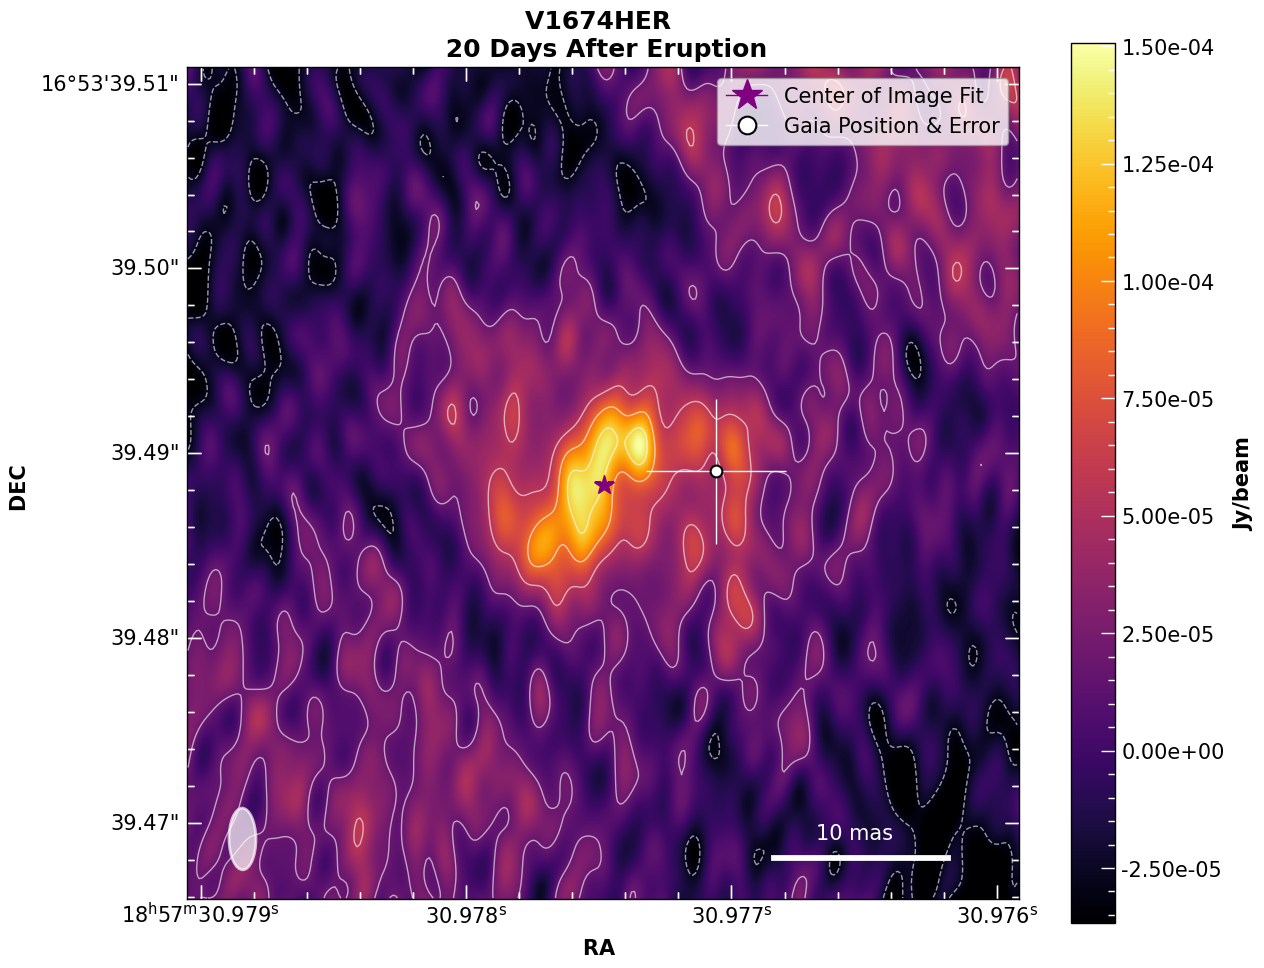

In [15]:
plt.style.use('./light.mplstyle');


figb = plt.figure(figsize=(13,11));
axb = figb.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
ra_b = axb.coords[0];
dec_b = axb.coords[1];


axb.set_title(f'V1674HER \n 20 Days After Eruption');
# plt.title(f'V1674HER \n 20 Days After Eruption', weight='bold');

imgb = axb.imshow(cutb_data, cmap='inferno', vmin=(rms_list[0]*-2), vmax=imgb_info['max'], 
                 transform=axb.get_transform(cut_wcsb), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutb_center, beamb, 10, axb); #finetune_ra=-7
beamb_patch = beam_plotter(beamb, cutb_center, axb);


cbar_b = figb.colorbar(imgb, format="%4.2e"); 
cbar_b.ax.set_ylabel('Jy/beam'); 

ra_b.set_axislabel('RA ');
dec_b.set_axislabel('DEC ');

ra_b.set_ticklabel('black'); #required
dec_b.set_ticklabel('black');

axb.add_patch(beamb_patch);
axb.add_patch(scale_bar);

# contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels_array = np.array((-1.5, 1, 3, 5, 7));
contour_levels =rms_list[0]*contour_levels_array;
axb.contour(cutb_data, levels=contour_levels , colors='w', alpha=0.6);


axb.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axb.get_transform('fk5'), color='w');

axb.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5, transform=axb.get_transform('fk5'),
             marker='.', markersize=17, markeredgecolor='black', label='Gaia Position & Error');

# axb.errorbar(modelfitb_coords.ra.degree, modelfitb_coords.dec.degree, yerr=modelfitb_yerr, xerr=modelfitb_xerr, transform=axb.get_transform('fk5'),
#               color='purple', marker='.', markersize=1, label='Center of Image Fit');

axb.plot(modelfitb_coords.ra.degree, modelfitb_coords.dec.degree, transform=axb.get_transform('fk5'),
           color='purple', marker='*', label='Center of Image Fit', markersize=15);

axb.legend();


### V1674HERD

In [16]:
imgd_data, wcsd, imaged = load('./V1674HERIMG/021225/V1674HERD_252s.fits');

imgd_info, imgd_cnt = info(imaged);

beamd = beam(imaged);

cutd_data, cut_wcsd, cutd_center = cut(imgd_data, wcsd, imgd_cnt, center_pos=modelfitb_coords, box=(300,300));

obstime_d = time.Time(imgd_info['obs_date'], scale='utc');
obstime_d.format = ('jd');
# obstime_b.scale = ('utc');

t_d = obstime_d - t_0;



time_diff_d = (obstime_d - gaia_time);
time_diff_d = (time_diff_d.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_d)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_d*rapm_err)**2)**(1/2);
t_d

modelfitd_xerr = ((modelfitd.iloc[0,3]*un.arcsec).to(un.degree)).value;
modelfitd_yerr = ((modelfitd.iloc[0,5]*un.arcsec).to(un.degree)).value;


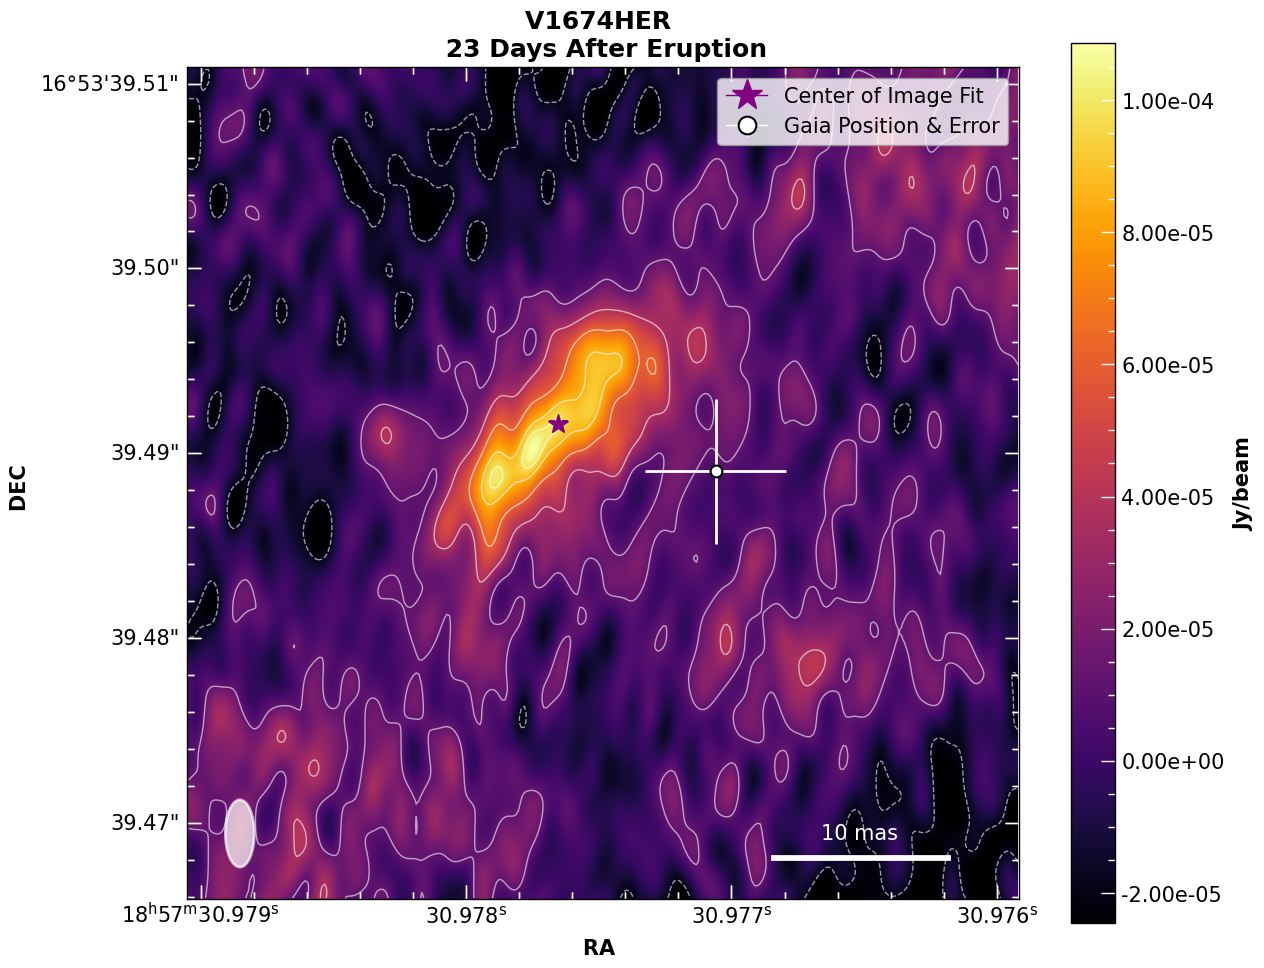

In [17]:
plt.style.use('./light.mplstyle');

figd = plt.figure(figsize=(13,11));
axd = figd.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
ra_d = axd.coords[0];
dec_d = axd.coords[1];
# plt.rcParams.update({'font.weight': 'heavy'});

axd.set_title(f'V1674HER \n 23 Days After Eruption');

imgb = axd.imshow(cutd_data, cmap='inferno', vmin=(rms_list[1]*-2), vmax=imgd_info['max'], 
                 transform=axd.get_transform(cut_wcsd), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutd_center, beamd, 10, axd, finetune_ra=2);
beamb_patch = beam_plotter(beamd, cutd_center, axd);


cbar_d = figd.colorbar(imgb, format="%4.2e"); 
cbar_d.ax.set_ylabel('Jy/beam'); 

ra_d.set_axislabel('RA ');
dec_d.set_axislabel('DEC ');

ra_d.set_ticklabel('black'); #required
dec_d.set_ticklabel('black');

axd.add_patch(beamb_patch);
axd.add_patch(scale_bar);

# contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels_array = np.array((-1.5, 1, 3, 5, 7, 8));
contour_levels = rms_list[1]*contour_levels_array;
axd.contour(cutd_data, levels=contour_levels ,transform=axd.get_transform(cut_wcsd), colors='w', alpha=0.6);

axd.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axd.get_transform('fk5'), color='w');

axd.plot(modelfitd_coords.ra.degree, modelfitd_coords.dec.degree, transform=axd.get_transform('fk5'),
           color='purple', marker='*', label='Center of Image Fit', markersize=15);

# axd.errorbar(modelfitd_coords.ra.degree, modelfitd_coords.dec.degree, yerr=modelfitd_yerr, xerr=modelfitd_xerr, transform=axd.get_transform('fk5'),
#               color='w', marker='.', label='Center of Image Fit');

axd.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axd.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error', elinewidth=2);
axd.legend();

### V1674HERF

In [18]:
# imgf_data, wcsf, imagef = load('./V1674HERIMG/011525/V1674HERF_252.fits');
imgf_data, wcsf, imagef = load('./V1674HERIMG/021225/V1674HERF_252st.fits');

imgf_info, imgf_cnt = info(imagef);

beamf = beam(imagef);

cutf_data, cut_wcsf, cutf_center = cut(imgf_data, wcsf, imgf_cnt, center_pos=modelfitb_coords, box=(300,300));

obstime_f = time.Time(imgf_info['obs_date'], scale='utc');
obstime_f.format = ('jd');
# obstime_b.scale = ('utc');

t_f = obstime_f - t_0;


time_diff_f = (obstime_f - gaia_time);
time_diff_f = (time_diff_f.value*un.day).to(un.year).value;

gaia_xerr = (ra_err**2+(rapm_err*time_diff_f)**2)**(1/2);
gaia_yerr = (dec_err**2+(time_diff_f*rapm_err)**2)**(1/2);

# modelfitf_xerr_1 = ((modelfitf.iloc[0,3]*un.arcsec).to(un.degree)).value;
# modelfitf_yerr_1 = ((modelfitf.iloc[0,5]*un.arcsec).to(un.degree)).value;
# modelfitf_xerr_2 = ((modelfitf.iloc[1,3]*un.arcsec).to(un.degree)).value;
# modelfitf_yerr_2 = ((modelfitf.iloc[1,5]*un.arcsec).to(un.degree)).value;

In [19]:
# modelf_sep = modelfitf_coords_1.separation(modelfitf_coords_2).to(un.mas);
# modelf_pa = modelfitf_coords_1.position_angle(modelfitf_coords_2).to(un.deg);

# dra, ddec = modelfitf_coords_1.spherical_offsets_to(modelfitf_coords_2);

# dra = (dra.to(un.arcsec))/2;
# ddec = (ddec.to(un.arcsec))/2;

# midpoint = modelfitf_coords_1.spherical_offsets_by(dra, ddec);
# midpoint


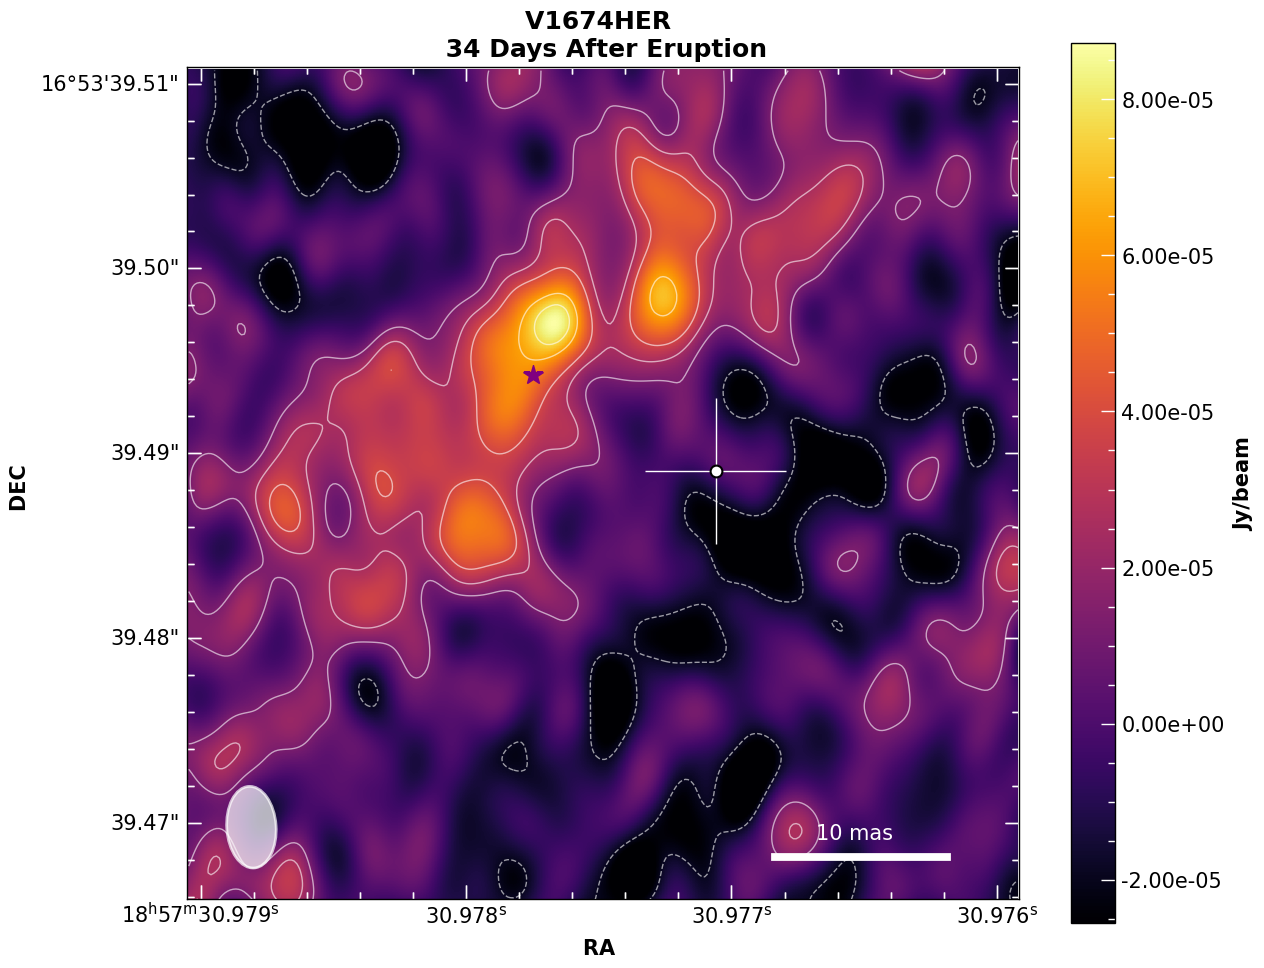

In [175]:
plt.style.use('./light.mplstyle');

figf = plt.figure(figsize=(13,11));
axf = figf.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
rad_f = axf.coords[0];
dec_f = axf.coords[1];


axf.set_title(f'V1674HER \n 34 Days After Eruption');

imgb = axf.imshow(cutf_data, cmap='inferno', vmin=(-2*rms_list[2]), vmax=imgf_info['max'], 
                 transform=axf.get_transform(cut_wcsf), origin='lower'); #set min to -2 or so of rms

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutf_center, beamf, 10, axf);
beamf_patch = beam_plotter(beamf, cutf_center, axf, finetune_ra=7, finetune_dec=3);


cbar_d = figf.colorbar(imgb, format="%4.2e"); 
cbar_d.ax.set_ylabel('Jy/beam'); 

rad_f.set_axislabel('RA ');
dec_f.set_axislabel('DEC ');

rad_f.set_ticklabel('black'); #required
dec_f.set_ticklabel('black');

axf.add_patch(beamf_patch);
axf.add_patch(scale_bar);

# contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels_array = np.array((-1.5, 1, 2, 3, 5, 6));
contour_levels = rms_list[2]*contour_levels_array;
axf.contour(cutf_data, levels=contour_levels ,transform=axf.get_transform(cut_wcsf), colors='w', alpha=0.6);

axf.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axf.get_transform('fk5'), color='w');
v1674herf_coords = SkyCoord('18:57:30.9747036153', '16:53:39.4639746068', unit=(un.hourangle, un.deg), frame='icrs').transform_to(frame='fk5');

axf.plot(modelfitf_coords.ra.degree, modelfitf_coords.dec.degree, transform=axf.get_transform('fk5'),
           markersize='15', color='purple', marker='*', label='Model Fit Center');

# axf.plot(modelfitf_coords_2.ra.degree, modelfitf_coords_2.dec.degree, transform=axf.get_transform('fk5'),
#            markersize='15', color='purple', marker='*', label='Model Fit Center');

# axf.errorbar(modelfitf_coords_1.ra.degree, modelfitf_coords_1.dec.degree, yerr=modelfitf_yerr_1, xerr=modelfitf_xerr_1, transform=axf.get_transform('fk5'),
#               color='purple', marker='*', markersize=15, label='Center of Image Fit');

# axf.errorbar(modelfitf_coords_2.ra.degree, modelfitf_coords_2.dec.degree, yerr=modelfitf_yerr_2, xerr=modelfitf_xerr_2, transform=axf.get_transform('fk5'),
#               color='purple', marker='*', markersize=15, label='Center of Image Fit');

axf.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axf.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');
# plt.savefig('./011525/V1674HERF.png');

### V1674HERBDF

In [177]:

def get_angle_yaxis(line, center_value, beam_dict, size_mas, ax_name):
    """This finds the angle between the yaxis and the line plotted. It only uses the first 
    and last values of the line!!!"""
    lxy = line.get_xydata();
    # print(lxy[-1][0]);
 
    #get data
    slope = (float(lxy[-1][1] - lxy[0][1]) / float(lxy[-1][0] - lxy[0][0]));
    # theta = abs(math.degrees(math.atan(slope))); # for angle w xaxis
    theta = (90 -abs(math.degrees(math.atan(slope)))); #for angle w yaxis
    print(theta);
    size = scale(beam_dict, size_mas)
    arc_patch = Arc(center_value, size, size, angle=0,theta1=theta, theta2=90, label=str(theta)+u"\u00b0", transform=ax_name.get_transform('fk5'),
                    color='purple', alpha=0.95, lw=5);
    return arc_patch
# x = [modelfitb_coords.ra.degree, modelfitd_coords.ra.degree, modelfitf_coords.ra.degree];
# y = [modelfitb_coords.dec.degree, modelfitd_coords.dec.degree, modelfitf_coords.dec.degree];

# lined = Line2D(x, y, transform=axb.get_transform('fk5'), linewidth=2, color='w', marker='.');

def get_angle_line_yaxis(line, center_value, beam_dict, size_mas, ax_name):
    slope, _ = np.polyfit(x,y,1);

    theta_plt = (abs(math.degrees(math.atan(slope)))); #for angle w yaxis
    theta = (90-theta_plt);
    print(theta);
    
    size = scale(beam_dict, size_mas);
    arc_patch = Arc(center_value, size, size, angle=0, theta1=theta_plt, theta2=90, label=str(theta)+u"\u00b0", transform=ax_name.get_transform('fk5'),
                    color='purple', alpha=0.95, lw=5);
    return arc_patch


34.376789229051184


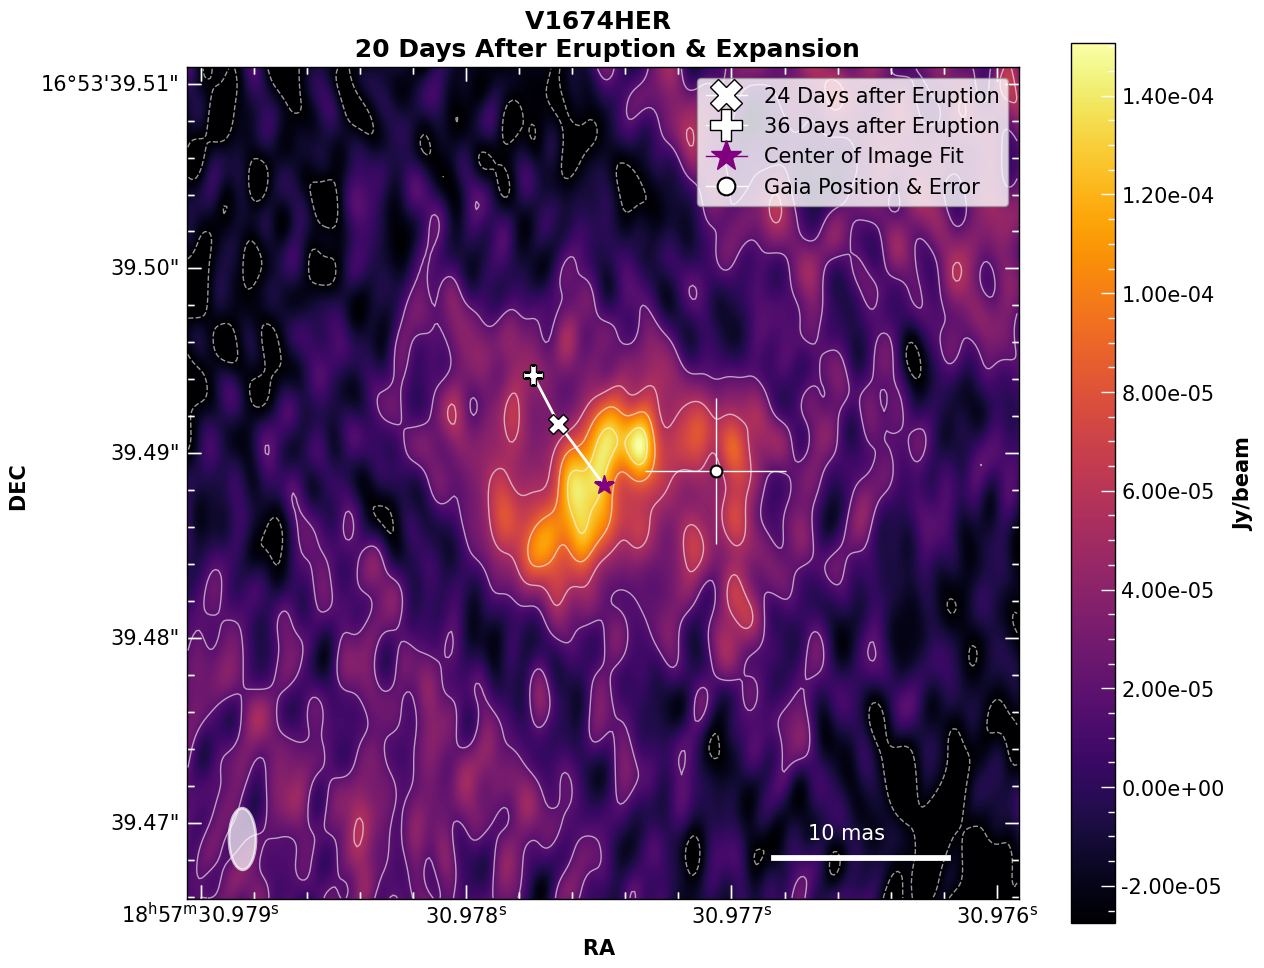

In [178]:
plt.style.use('./light.mplstyle');
plt.rcParams.update({'font.weight': 'normal'});


figb = plt.figure(figsize=(13,11));
axb = figb.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
ra_b = axb.coords[0];
dec_b = axb.coords[1];


axb.set_title(f'V1674HER \n 20 Days After Eruption & Expansion');

imgb = axb.imshow(cutb_data, cmap='inferno', vmin=rms_list[0]*-1.5, vmax=imgb_info['max'], 
                 transform=axb.get_transform(cut_wcsb), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutb_center, beamb, 10, axb, finetune_ra=-3); #finetune_ra=-7
beamb_patch = beam_plotter(beamb, cutb_center, axb);


cbar_b = figb.colorbar(imgb, format="%4.2e"); 
cbar_b.ax.set_ylabel('Jy/beam'); 

ra_b.set_axislabel('RA ');
dec_b.set_axislabel('DEC ');

ra_b.set_ticklabel('black'); #required
dec_b.set_ticklabel('black');

axb.add_patch(beamb_patch);
axb.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 1, 3, 5, 7));
contour_levels = rms_list[0]*contour_levels_array;
axb.contour(cutb_data, levels=contour_levels , colors='w', alpha=0.6);

axb.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axb.get_transform('fk5'), color='w');

axb.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axb.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');

x = [modelfitb_coords.ra.degree, modelfitd_coords.ra.degree, modelfitf_coords.ra.degree];
y = [modelfitb_coords.dec.degree, modelfitd_coords.dec.degree, modelfitf_coords.dec.degree];
lined = Line2D(x, y, transform=axb.get_transform('fk5'), linewidth=2, color='w', marker='.');

angle_arc = get_angle_line_yaxis(lined, [modelfitb_coords.ra.degree, modelfitb_coords.dec.degree], beamb, 5, axb);

axb.add_line(lined);
# axb.add_patch(angle_arc); #arc showing 45 deg angle

# axb.plot([x[0],x[-1]], [y[0],y[-1]], transform=axb.get_transform('fk5'), color='white', lw=2, alpha=0.75);

axb.plot(modelfitd_coords.ra.degree, modelfitd_coords.dec.degree, transform=axb.get_transform('fk5'), 
         marker='X', color='white', label='24 Days after Eruption',  markersize=15, markeredgewidth=1, markeredgecolor='black');

axb.plot(modelfitf_coords.ra.degree, modelfitf_coords.dec.degree, transform=axb.get_transform('fk5'), markersize=15, marker='P', label='36 Days after Eruption',
         color='white', markeredgewidth=1, markeredgecolor='black');

# axb.plot(midpoint.ra.degree, midpoint.dec.degree, transform=axb.get_transform('fk5'),markersize=15, marker='P', label='34 Days after Eruption',
#          color='white', markeredgewidth=1, markeredgecolor='black');

# axb.plot(kirill_gaia.ra.degree, kirill_gaia.dec.degree, marker='*', transform=axb.get_transform('fk5'), markersize=19);

# axb.plot(cent
# er.ra.degree, center.dec.degree, marker='*', transform=axb.get_transform('fk5'), markersize=19);

axb.plot(modelfitb_coords.ra.degree, modelfitb_coords.dec.degree, transform=axb.get_transform('fk5'),
         markersize=15, color='purple', marker='*', label='Center of Image Fit');
axb.legend();
# print(modelfitb_coords.ra.degree, modelfitb_coords.dec.degree);


In [ ]:
# print(f'{modelfitf.iloc[1,0]*1e3:.3E}')
# print(f'{modelfitf.iloc[1,1]*1e6:.3E}')
rms_list

In [ ]:
modelfitb_coords.ra.hms

In [ ]:
modelfitb

## Check & Phase Reference Source

In [ ]:
# # checksrcb, checksrcb_coords = difmap_model_read('./check/fitb.txt');
# checkb_coords = SkyCoord('19:04:46.2574282526', '16:03:15.0463412082', unit=(un.hourangle, un.deg));
# checkd_coords = SkyCoord('19:04:46.2574099526','16:03:15.0463069188', unit=(un.hourangle, un.deg));
# checkf_coords = SkyCoord('19:04:46.2574062314','16:03:15.0463550053', unit=(un.hourangle, un.deg));
# checkf_coords_icrs = SkyCoord('19:04:46.254662979', '16:03:15.0221210724', unit=(un.hourangle, un.deg), frame='icrs');
# v1674herb_coords = SkyCoord('18:57:30.9747036153', '16:53:39.4639746068', unit=(un.hourangle, un.deg), frame='icrs');



# checksched_coords = SkyCoord('19:04:46.2573', '+16:03:15.046', unit=(un.hourangle, un.degree)); #1902+159
# prsched_coords = SkyCoord('18:57:25.5956', '+16:24:55.841', unit=(un.hourangle, un.degree)); #1855+163
# ffsched_coords = SkyCoord('17:51:32.8186', '+09:39:00.728', unit=(un.hourangle, un.deg)); #1749+096
# v1674her_sched = SkyCoord('18:57:30.979', '+16:53:39.54', unit=(un.hourangle, un.deg));

# checkcal_coords = SkyCoord('19:04:46.25735000', '+16:03:15.0459200', unit=(un.hourangle, un.deg)); #RFC
# prcal_coords = SkyCoord(' 18:57:25.59555586 ', '+16:24:55.8404388', unit=(un.hourangle, un.degree));

# sep_bd = (checkb_coords.separation(checkd_coords));
# sep_df = (checkf_coords.separation(checkd_coords));
# sep_bf = (checkb_coords.separation(checkf_coords));

# sep_schedcal = (checksched_coords.separation(checkcal_coords)).to(un.mas);
# sep_schedb = (checksched_coords.separation(checkb_coords)).to(un.mas);


# print(sep_bd, sep_df, sep_bf);
# print(sep_schedcal, sep_schedb);
# print(checksched_coords.separation(checkf_coords_icrs).to(un.mas));
# print(shifted_gaia.separation(modelfitb_coords));



# dist = (6.3e3)*un.pc
# dis_per = 3.8e3*un.pc;
# dis_ner = 2.8e3*un.pc;
# carta_icrs = SkyCoord('18:57:25.5928698300', '+16:24:55.8164494212', unit=(un.hourangle, un.deg), frame='icrs');
# RCF_icrs = SkyCoord('18:57:25.59555586', '+16:24:55.8404388', unit=(un.hourangle, un.degree), frame='icrs');

# diff = carta_icrs.separation(RCF_icrs).to(un.mas);
# img_diff = shifted_gaia.separation(modelfitb_coords).to(un.mas);
# D = np.tan(sep_bd.to(un.arcsec))*dist;

# print(D.to(un.AU))
# sep_s = (shifted_gaia.ra.degree - modelfitf_coords.ra.degree)**2 + ((shifted_gaia.dec.degree - modelfitf_coords.dec.degree)**2)
# sep = (sep_s)**(1/2)
# sep_mas = (sep*un.degree).to(un.mas)
# print(sep_mas)

# Analysis

## Distance & Angular Size

In [ ]:
print("angular size on epoch B");
Diamb_au, Diamb_pc = angsize_difmap(6.3e3, modelfitb, dist_ler=-2.8e3, dist_uer=3.8e3);
print("angular size on epoch D");
Diamd_au, Diamd_pc = angsize_difmap(6.3e3, modelfitd, dist_ler=-2.8e3, dist_uer=3.8e3);
print("angular size on epoch F");
Diamf_au, Diamf_pc = angsize_difmap(6.3e3, modelfitf, dist_ler=-2.8e3, dist_uer=3.8e3);

angular size on epoch B


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

angular size on epoch D


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

angular size on epoch F


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Brightness Temperature

In [108]:
print('brightness temp from epoch b');
Tb_dfb = brightness_temp_difmap(modelfitb);
print('brightness temp from epoch d');
Tb_dfd = brightness_temp_difmap(modelfitd);
print('brightness temp from epoch f');
Tb_dff = brightness_temp_difmap(modelfitf);

brightness temp from epoch b


<IPython.core.display.Latex object>

brightness temp from epoch d


<IPython.core.display.Latex object>

brightness temp from epoch f


<IPython.core.display.Latex object>

## Magnetic Field

In [ ]:
print('Magnetic Field from epoch B');
B_listb = B_field_er_difmap(modelfitb, Diamb_pc);
print('Magnetic Field from epoch D');
B_listd = B_field_er_difmap(modelfitd, Diamd_pc);
print('Magnetic Field from epoch F');
B_listf = B_field_er_difmap(modelfitf, Diamf_pc);

Magnetic Field from epoch B


<IPython.core.display.Latex object>

Magnetic Field from epoch D


<IPython.core.display.Latex object>

Magnetic Field from epoch F


<IPython.core.display.Latex object>

## Opacity 

In [160]:
print("Opacity for epoch b");
op_listb = EM_this(imgb_info['max'], rms_list[0], modelfitb.iloc[0,15], Diamb_pc);
print("Opacity for epoch d");
op_listd = EM_this(imgd_info['max'], rms_list[1], modelfitd.iloc[0,15], Diamd_pc);
print("Opacity for epoch f");
op_listf = EM_this(imgf_info['max'], rms_list[2], modelfitf.iloc[0,15], Diamf_pc);

Opacity for epoch b


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Opacity for epoch d


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Opacity for epoch f


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Magnetic Pressure

In [172]:
print('magnetic pressure from epoch b');
Pb_minb, Pb_eqb = press_mage(B_listb);
print('magnetic pressure from epoch d');
Pb_mind, Pb_eqd = press_mage(B_listd);
print('magnetic pressure from epoch f');
Pb_minf, Pb_eqf = press_mage(B_listf);

magnetic pressure from epoch b


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

magnetic pressure from epoch d


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

magnetic pressure from epoch f


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Ideal Pressure

In [163]:
print("ideal gas pressure from epoch b");
ideal_pb = ideal_pres_list(op_listb);
print("ideal gas pressure from epoch d");
ideal_pd = ideal_pres_list(op_listd);
print("ideal gas pressure from epoch f");
ideal_pf = ideal_pres_list(op_listf);

ideal gas pressure from epoch b


<IPython.core.display.Latex object>

ideal gas pressure from epoch d


<IPython.core.display.Latex object>

ideal gas pressure from epoch f


<IPython.core.display.Latex object>

## Dynamic Pressure

In [171]:
print("Dynamic Pressure from epoch b");
P_dynb = dyn_press_list(op_listb, 5000e3, 0);
print("Dynamic Pressure from epoch d");
P_dynd = dyn_press_list(op_listd, 5000e3, 0);
print("Dynamic Pressure from epoch f");
P_dynf = dyn_press_list(op_listf, 5000e3, 0);

Dynamic Pressure from epoch b


<IPython.core.display.Latex object>

Dynamic Pressure from epoch d


<IPython.core.display.Latex object>

Dynamic Pressure from epoch f


<IPython.core.display.Latex object>

# Light Curve

### Generic Plot

In [ ]:
lc_df = pd.read_csv('./tables/V1674HERLC.csv',delimiter=',');

VLBA = pd.DataFrame([[t_b.value, (modelfitb.iloc[0,0]*1e3)],[t_d.value,modelfitd.iloc[0,0]*1e3], [t_f.value, modelfitf.iloc[0,0]*1e3]],
                    columns = ['Day',  'Flux']);

bands = pd.DataFrame([['c', 5.1],['x', 7.0],['ku', 13.7],['k', 16.5],['ka', 31.1],['q', 34.9]],
                     columns=['name','freq']);


#do not try this at home
#this for loop is bad form, but still works
for i in range(0, len(bands)):
    
    name_i = bands.iloc[i,0];
    freq_i = bands.iloc[i,1];
    
    var_name = 'lc_' + str(name_i);
    globals()[var_name] = lc_df.loc[lc_df['Freq'] == freq_i];
    
    
    var_i = eval(var_name); 
    #create non-detection dataframes
    var_name2 = (var_name + '_nd');
    globals()[var_name2] = var_i.loc[var_i['Unnamed: 4'] == 'non-detection'];
    
    #create detection dataframes
    var_name3 = (var_name + '_d');
    globals()[var_name3] = (var_i.loc[var_i['Unnamed: 4'] != 'non-detection']);
    

#now have three dataframes:
    #lc_(band)_nd: which is all the ones which were indicated to be nondetections
    #lc_(band)_d: which are the ones which were indicated to be anything other than nondetections
    #lc_(band) which is a combination of the other two
# VLBA.to_csv('./VLBA.csv'); #save to csv for sanity

In [ ]:
plt.style.use('./presentation.mplstyle');
fig, ax = plt.subplots(figsize=(17,11), facecolor='white');
plt.rcParams.update({'lines.markersize': 15});




line_c, = ax.plot(lc_c_d['Day'], lc_c_d['Flux'], linestyle='dashed' , marker='.', color='indigo');
line_x, = ax.plot(lc_x_d['Day'], lc_x_d['Flux'], linestyle='dashed',  marker='.' , color='steelblue');
line_ku, = ax.plot(lc_ku_d['Day'], lc_ku_d['Flux'],linestyle='dashed', marker='.' , color='olive');
line_k, = ax.plot(lc_k_d['Day'], lc_k_d['Flux'], linestyle='dashed', marker='.' , color='darkorange');
line_q, = ax.plot(lc_q_d['Day'], lc_q_d['Flux'], linestyle='dashed', marker='.' , color='firebrick');


#ax.errorbar(lc_ka_d['Day'], lc_ka_d['Flux'], linestyle='dashed', linewidth=0.75,marker='.', color='firebrick', label='31 GHz');
#non-detections
line_c_nd, = ax.plot(lc_c_nd['Day'], lc_c_nd['Flux'], marker='X', linestyle='none',    color='indigo');
line_x_nd, = ax.plot(lc_x_nd['Day'], lc_x_nd['Flux'], marker='X', linestyle='none',   color='steelblue');
line_ku_nd, = ax.plot(lc_ku_nd['Day'], lc_ku_nd['Flux'], marker='X',linestyle='none',    color='olive');
line_k_nd, = ax.plot(lc_k_nd['Day'], lc_k_nd['Flux'], marker='X', linestyle='none',   color='darkorange');
#ax.scatter(lc_ka_nd['Day'], lc_ka_nd['Flux'], marker='+', color='firebrick');
line_q_nd, = ax.plot(lc_q_nd['Day'], lc_q_nd['Flux'], marker='X',   linestyle='none', color='firebrick');

# ax.errorbar()
#VLBA
line_VLBA, = ax. plot(VLBA['Day'], VLBA['Flux'], linestyle='dashed', marker='*', markersize=15, color='crimson');

ax.set_xscale('log');
ax.set_yscale('log');
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'));
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'));
ax.tick_params(which='both', direction='in', length=13, width=2);
ax.legend([line_c, line_x, line_ku, line_k, line_q, (line_c_nd, line_x_nd, line_ku_nd, line_k_nd, line_q_nd), line_VLBA],
          ['4.7 GHz', '7.2 GHz', '13.5 GHz', '16.5 GHz', '35 GHz', 'non-detection','VLBA, 4.7GHz' ], handler_map={tuple: HandlerTuple(ndivide=None)});

ax.grid(True, alpha=0.25);

#ax.set_xlim(7,1000);
ax.set_ylim(0.005, 10);
ax.set_title('V1674Her Cute Radio Light Curve + VLBA');
ax.set_ylabel('Flux Density (mJy)');
ax.set_xlabel('Day After Detection');

##### LC with error bars

In [ ]:
plt.style.use('./light.mplstyle');
fig, ax = plt.subplots(figsize=(17,9), facecolor='white');
plt.rcParams.update({'lines.markersize': 9});




line_c = ax.errorbar(lc_c_d['Day'], lc_c_d['Flux'], xerr=0, yerr=lc_c_d['Error'], linestyle='dashed' , marker='.', color='indigo');
line_x = ax.errorbar(lc_x_d['Day'], lc_x_d['Flux'], xerr=0, yerr=lc_x_d['Error'], linestyle='dashed',  marker='.' , color='steelblue');
line_ku = ax.errorbar(lc_ku_d['Day'], lc_ku_d['Flux'], xerr=0, yerr=lc_ku_d['Error'],linestyle='dashed', marker='.' , color='olive');
line_k = ax.errorbar(lc_k_d['Day'], lc_k_d['Flux'],xerr=0, yerr=lc_k_d['Error'], linestyle='dashed', marker='.' , color='darkorange');
line_q = ax.errorbar(lc_q_d['Day'], lc_q_d['Flux'], xerr=0, yerr=lc_q_d['Error'],linestyle='dashed', marker='.' , color='firebrick');


#ax.errorbar(lc_ka_d['Day'], lc_ka_d['Flux'], linestyle='dashed', linewidth=0.75,marker='.', color='firebrick', label='31 GHz');
#non-detections
line_c_nd = ax.errorbar(lc_c_nd['Day'], lc_c_nd['Flux'], xerr=0, yerr=lc_c_nd['Error'], marker='X', linestyle='none',    color='indigo');
line_x_nd = ax.errorbar(lc_x_nd['Day'], lc_x_nd['Flux'], xerr=0, yerr=lc_x_nd['Error'], marker='X', linestyle='none',   color='steelblue');
line_ku_nd = ax.errorbar(lc_ku_nd['Day'], lc_ku_nd['Flux'], xerr=0, yerr=lc_ku_nd['Error'], marker='X',linestyle='none',    color='olive');
line_k_nd = ax.errorbar(lc_k_nd['Day'], lc_k_nd['Flux'], xerr=0, yerr=lc_k_nd['Error'],marker='X', linestyle='none',   color='darkorange');
#ax.scatter(lc_ka_nd['Day'], lc_ka_nd['Flux'], marker='+', color='firebrick');
line_q_nd = ax.errorbar(lc_q_nd['Day'], lc_q_nd['Flux'],xerr=0, yerr=lc_q_nd['Error'], marker='X',   linestyle='none', color='firebrick');

# ax.errorbar()
#VLBA


ax.set_xscale('log');
ax.set_yscale('log');
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'));
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'));
ax.tick_params(which='both', direction='in', length=13, width=2);
ax.legend([line_c, line_x, line_ku, line_k, line_q, (line_c_nd, line_x_nd, line_ku_nd, line_k_nd, line_q_nd), line_VLBA],
          ['4.7 GHz', '7.2 GHz', '13.5 GHz', '16.5 GHz', '35 GHz', 'non-detection','VLBA, 4.7GHz' ], handler_map={tuple: HandlerTuple(ndivide=None)});
line_VLBA = ax.plot(VLBA['Day'], VLBA['Flux'], linestyle='dashed', marker='*', markersize=15, color='crimson');
ax.grid(True, alpha=0.25);

#ax.set_xlim(7,1000);
ax.set_ylim(0.005, 10);
ax.set_title('V1674Her Light Curve VLA + VLBA');
ax.set_ylabel('Flux Density (mJy)');
ax.set_xlabel('Day After Detection');

### Plot MCMC fit w/Errors

In [ ]:
def broken_powerlaw(t, t_b, beta_1, beta_2, F_c):
    #Granot & sari 2002
    s = 0.61;    
    a = (t/t_b)**(-s*beta_1);
    b = (t/t_b)**(-s*beta_2);

    F_nu = F_c*(a+b)**(-1/s);
    
    return F_nu

In [ ]:
VLBA = pd.read_csv('./tables/VLBA.csv', delimiter=',');

#values from the ML fit
t_bml, beta_1ml, beta_2ml, F_cml = [17.326622802099042, -1.5908098504656645, 9.325492883689463, 5.100127];

t_line = np.linspace(10,500,10000);
newy = broken_powerlaw(t_line, t_bml, beta_1ml, beta_2ml, F_cml);

VLBA_pl_ML = broken_powerlaw(VLBA['Day'], t_bml, beta_1ml, beta_2ml, F_cml);

#values from 2nd MCMC
lower = np.array([0.56, 0.16, 1.23, 0.48]);
upper = np.array([0.57, 0.16, 1.29, 0.47]);
emcee_values = np.array([17.63, -1.61, 8.62, 5.08]);
emcee_lower = emcee_values - lower;
emcee_upper = emcee_values + upper;

VLBA_pl_EMCEE = broken_powerlaw(VLBA['Day'], emcee_values[0], emcee_values[1], emcee_values[2], emcee_values[3]);

In [ ]:
#read in data
lc_c = pd.read_csv('./tables/lc_c.csv',delimiter=',');
#VLBA = pd.read_csv('./VLBA.csv', delimiter=',');
lc_c =  lc_c.iloc[:, 1:-1];
x = np.linspace(lc_c.iloc[0,0], lc_c.iloc[-1,0], num=100);
t = lc_c.iloc[:,0].to_numpy(dtype=np.float128);
y = lc_c.iloc[:,2].to_numpy(dtype=np.float128);
yerr = lc_c.iloc[:,3].to_numpy(dtype=np.float128);
x0 = np.linspace(t[0], t[-1], num=100);

t_line = np.linspace(10,500,10000);
newy = broken_powerlaw(t_line, t_bml, beta_1ml, beta_2ml, F_cml);


In [ ]:
plt.style.use('./light.mplstyle');
fig, ax = plt.subplots(figsize=(17,11), facecolor='white');
plt.rcParams.update({'lines.linewidth':2});

# t_line = np.linspace(10,500,10000);




plt.errorbar(t,y,yerr, xerr=0, marker='.', markersize=15, linewidth=2, color='purple', label='VLA 4.7GHz');

ax.plot(t_line, newy, linestyle='dashed', color='steelblue',  label="ML broken powerlaw fit", zorder=10); #(0, (5, 1,, 1, 1))



lower_emcee = broken_powerlaw(t_line, emcee_lower[0],  emcee_lower[1],  emcee_lower[2], emcee_lower[3]);

values_emcee = broken_powerlaw(t_line, emcee_values[0], emcee_values[1], emcee_values[2], emcee_values[3]);

upper_emcee = broken_powerlaw(t_line, emcee_upper[0], emcee_upper[1], emcee_upper[2], emcee_upper[3]);

ax.plot(t_line, lower_emcee, linestyle='solid', color='indigo',  label="EMCEE Lower Bounds");

ax.plot(t_line, values_emcee, linestyle='solid', color='mediumvioletred',  label="EMCEE", zorder=15);

ax.plot(t_line, upper_emcee, linestyle='solid', color='mediumorchid',  label="EMCEE Upper Bounds");

ax.fill_between(t_line, lower_emcee, upper_emcee, alpha=0.5, color='thistle', zorder=0);

# ax.scatter(VLBA['Day'], VLBA_pl_ML, label='Estimate using ML', color='red', s=75, marker='X');
ax.scatter(VLBA['Day'], VLBA_pl_EMCEE, label='Estimate using ML', color='mediumvioletred', s=150, marker='P', zorder=20);

ax.plot(VLBA['Day'], VLBA['Flux'], linestyle='dashed', marker='*', markersize=15, color='crimson', label='VLBA 4.7GHz', zorder=5);


#set labels and whatnot
ax.set_title('V1674 Her Light Curve + Estimates');
ax.set_ylabel('Flux Density (mJy)');
ax.set_xlabel('Day After Detection');
ax.grid(True, alpha=0.25);

ax.set_xscale('log');
ax.set_yscale('log')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'));
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'));
plt.legend();
